In [1]:
from scipy.integrate import solve_ivp
from numba import njit
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
from time import time
from statistics import mean, stdev
import json

In [2]:
def GenerateParams_SIR_lagrange(K):

    Out = np.random.rand(K,K)
    np.fill_diagonal(Out,0)
    In = np.random.rand(K,K)
    np.fill_diagonal(In,0)
    Beta = np.random.rand(K)
    Gamma = np.random.rand(K)

    return Out, In, Beta, Gamma

def GenerateY0_SIR_lagrange(K):
    y0 = np.zeros((4,K,K))
    np.fill_diagonal(y0[0], 1995)
    np.fill_diagonal(y0[1], 5)
    np.fill_diagonal(y0[3], 2000)
    y0.resize((4*K*K,))
    return y0

In [12]:
# IMPORTANTE NO EJECUTAR!!!
# a menos que quiera generar un nuevo juego de datos


matrix_test_lagrange = {}
for i in range(2,21):
    matrix_test_lagrange[i] = []
    for j in range(30):
        params = GenerateParams_SIR_lagrange(K = i)
        matrix_test_lagrange[i].append(params)
np.savez_compressed('params_dataset', matrix_test_lagrange= matrix_test_lagrange)

pass

In [4]:
loaded = np.load('params_dataset.npz', allow_pickle=True)
matrix_test_lagrange = loaded['matrix_test_lagrange'].reshape(-1)[0]

In [5]:
def graph_individual_time_complexity(times_method):
    means = []
    stdevs = []
    ts = []
    for t, times in times_method.items():
        means.append(mean(times))
        stdevs.append(stdev(times))
        ts.append(t)
    plt.plot(ts, means, color='red')
    plt.plot(ts, np.array(means) + np.array(stdevs), '--', color='black')
    plt.plot(ts, np.array(means) - np.array(stdevs), '--', color='black')
    plt.grid()
    plt.show()

## Caso 1

En este caso `gen_fun_sir_lagrange` recibe los parámetros del modelo y genera una función para evaluar el modelo con estos parámetros ya insertados. Por lo tanto una vez generada la nueva función esta es la que se debe utilizar para buscar una solución numérica al SEDO.

In [6]:
def gen_fun_sir_lagrange(Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)
    def fun(t,y):
        y.resize((4,K,K))
        I_k_i = y[1].sum(axis=0)
        N_k_i = y[3].sum(axis=0)
        new_y = np.zeros((4,K,K))
        for i in range(K):
            for j in range(K):
                if i == j:
                    new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                    y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                    new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                    y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                    new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                    y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                    new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
                else:
                    new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                    In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                    new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                    new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                    new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]
                                   
        y.resize((4*K*K,))
        new_y.resize((4*K*K,))
        return new_y
    return fun

In [16]:
times_lagrange_method_1 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_1[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(gen_fun_sir_lagrange(*params), (0, 500), y0), number= 1)
        times_lagrange_method_1[i].append(time)
np.savez_compressed('times_lagrange_method_1', times_lagrange_method_1=times_lagrange_method_1)

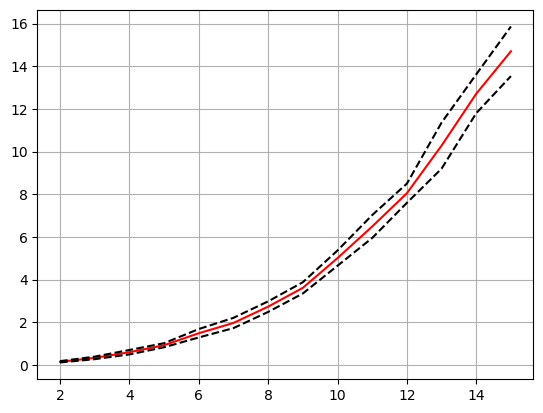

In [17]:
graph_individual_time_complexity(times_lagrange_method_1)

## Caso 2

En este caso `fun_sir_lagrange` recibe tanto los parámetros del modelo, como puede ser usado para evaluarlo. Por lo tanto esta función se debe utilizar directamente para buscar una solución numérica al SEDO.

In [18]:
def fun_sir_lagrange(t,y,Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)

    y.resize((4,K,K))
    I_k_i = y[1].sum(axis=0)
    N_k_i = y[3].sum(axis=0)
    new_y = np.zeros((4,K,K))
    for i in range(K):
        for j in range(K):
            if i == j:
                new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
            else:
                new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]
                                
    y.resize((4*K*K,))
    new_y.resize((4*K*K,))
    return new_y

In [19]:
times_lagrange_method_2 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_2[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_sir_lagrange, (0, 500), y0, args=params), number= 1)
        times_lagrange_method_2[i].append(time)
np.savez_compressed('times_lagrange_method_2', times_lagrange_method_2=times_lagrange_method_2)

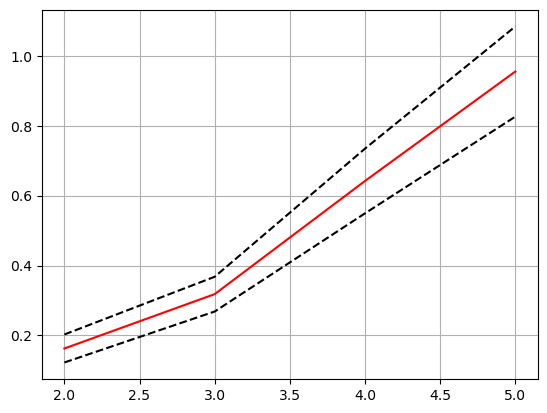

In [ ]:
graph_individual_time_complexity(times_lagrange_method_2)

## Caso 3

Similar al **Caso 1** donde ahora `gen_fun_sir_lagrange_numba` recibe los parámetros del modelo y genera una función para evaluar el modelo con estos parámetros ya insertados, pero esta función generada se decora con `njit` forzando que se compile en primera instancia. Por lo tanto una vez generada la nueva función esta es la que se debe utilizar para buscar una solución numérica al SEDO.

In [ ]:
def gen_fun_sir_lagrange_numba(Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)
    @njit
    def fun(t,y):
        y = y.reshape((4,K,K))
        I_k_i = y[1].sum(axis=0)
        N_k_i = y[3].sum(axis=0)
        new_y = np.zeros((4,K,K))
        for i in range(K):
            for j in range(K):
                if i == j:
                    new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                    y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                    new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                    y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                    new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                    y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                    new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
                else:
                    new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                    In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                    new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                    new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                    In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                    new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]

        new_y = new_y.reshape((4*K*K,))
        return new_y
    return fun

In [ ]:
times_lagrange_method_3 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_3[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(gen_fun_sir_lagrange_numba(*params), (0, 500), y0), number= 1)
        times_lagrange_method_3[i].append(time)
np.savez_compressed('times_lagrange_method_3', times_lagrange_method_3=times_lagrange_method_3)

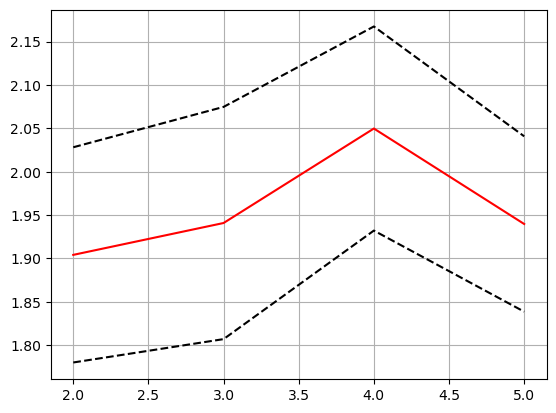

In [ ]:
graph_individual_time_complexity(times_lagrange_method_3)

## Caso 4

Similar al **Caso 2** donde en este caso `fun_sirfun_sir_lagrange_numba_lagrange` recibe tanto los parámetros del modelo, como puede ser usado para evaluarlo, pero se utiliza `njit` para decorarla y trabajar con una versión compilada de esta. Por lo tanto esta función se debe utilizar directamente para buscar una solución numérica al SEDO.

In [7]:
@njit
def fun_sir_lagrange_numba(t,y,Out, In, Beta, Gamma):
    
    K = Out.shape[0]
    Out_i_k = Out.sum(axis=1)

    y = y.reshape((4,K,K))
    I_k_i = y[1].sum(axis=0)
    N_k_i = y[3].sum(axis=0)
    new_y = np.zeros((4,K,K))
    for i in range(K):
        for j in range(K):
            if i == j:
                new_y[0,i,i] = - Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - \
                                y[0,i,i] * Out_i_k[i] + (In[i,] * y[0,i]).sum()
                new_y[1,i,i] =   Beta[i] * y[0,i,i] * I_k_i[i] / N_k_i[i] - Gamma[i] * y[1,i,i] - \
                                y[1,i,i] * Out_i_k[i] + (In[i,] * y[1,i]).sum()
                new_y[2,i,i] =   Gamma[i] * y[1,i,i] - \
                                y[2,i,i] * Out_i_k[i] + (In[i,] * y[2,i]).sum()
                new_y[3,i,i] = - y[3,i,i] * Out_i_k[i] + (In[i,] * y[3,i]).sum()
            else:
                new_y[0,i,j] = - Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - \
                                In[i,j] * y[0,i,j] + Out[i,j] * y[0,i,i]
                new_y[1,i,j] =   Beta[j] * y[0,i,j] * I_k_i[j] / N_k_i[j] - Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[1,i,j] + Out[i,j] * y[1,i,i]
                new_y[2,i,j] =   Gamma[j] * y[1,i,j] - \
                                In[i,j] * y[2,i,j] + Out[i,j] * y[2,i,i]
                new_y[3,i,j] = - In[i,j] * y[3,i,j] + Out[i,j] * y[3,i,i]

    new_y = new_y.reshape((4*K*K,))
    return new_y

In [14]:
times_lagrange_method_4 = {}
for i, arrays_params in matrix_test_lagrange.items():
    if i > 15:
        break
    times_lagrange_method_4[i] = []
    y0 = GenerateY0_SIR_lagrange(i)
    for params in arrays_params:
        time = timeit(lambda: solve_ivp(fun_sir_lagrange_numba, (0, 500), y0, args=params), number= 1)
        times_lagrange_method_4[i].append(time)
np.savez_compressed('times_lagrange_method_4', times_lagrange_method_4=times_lagrange_method_4)

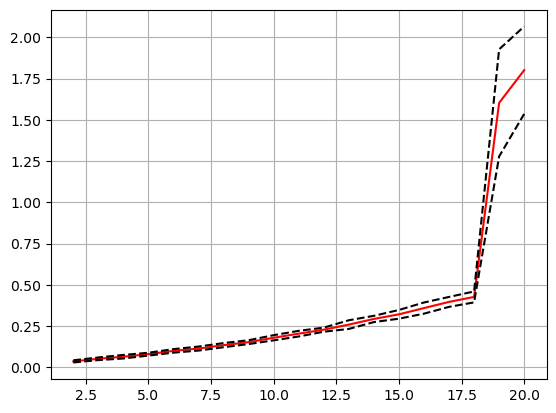

In [15]:
graph_individual_time_complexity(times_lagrange_method_4)